<a href="https://colab.research.google.com/github/fengwangunt/csce5218/blob/main/csce5218_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Documentation for the instructions about how to run it


1.   Download the data from https://www.kaggle.com/competitions/dog-breed-identification/data (requiring logging)
2.   Since test data don't have label to evaluate, we divide train data into three catergories: train, validation, and test.
3.   Select 0-8000 data from labels.csv to make train data called "train_in_train.csv", select 8000-9000 data from labels.csv to make validation data called "val_in_train.csv", the rest is for test data called "test_in_train.csv". Put these in the same directory of "dog-breed-identification".
4.   Install python libaries like pytorch, torchvision, transformers, py7zr and so on.
5.   Run it.
6.   Here is 7z file for data, you can use it directly if you don't download it.




In [49]:
!pip install py7zr

In [50]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sympy import limit
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel, AutoImageProcessor
import pandas as pd
from PIL import Image
import json
import random
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import py7zr

In [51]:
with py7zr.SevenZipFile('./dog-breed-identification.7z', mode='r') as archive:
    archive.extractall(path='./')

In [52]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [53]:
train_csv_file = './dog-breed-identification/train_in_train.csv'
val_csv_file = './dog-breed-identification/val_in_train.csv'
test_csv_file = './dog-breed-identification/test_in_train.csv'
img_dir = './dog-breed-identification/train/'

In [54]:
BATCH_SIZE = 1024
EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_CLASSES = 120

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model is using: {device}")

Model is using: cuda


In [56]:
os.makedirs('checkpoints/', exist_ok=True)
os.makedirs('logs/', exist_ok=True)

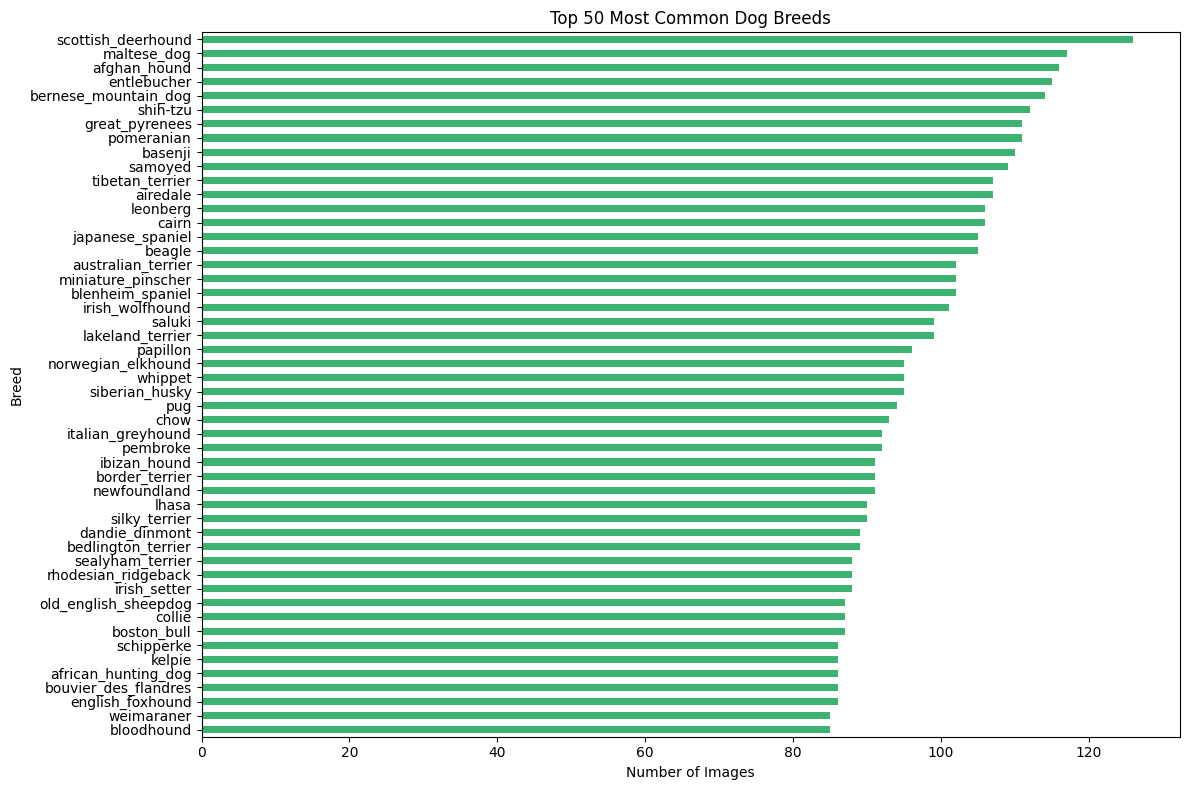

In [72]:
def drawBreed():
    data = pd.read_csv('./dog-breed-identification/labels.csv')
    top_50_breeds = data['breed'].value_counts().head(50)

    plt.figure(figsize=(12, 8))
    top_50_breeds.plot(kind='barh', color='mediumseagreen')
    plt.title("Top 50 Most Common Dog Breeds")
    plt.xlabel("Number of Images")
    plt.ylabel("Breed")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

drawBreed()

#Baseline Model
We will use the “most_frequent” baseline, first we will count the frequency of 120 breeds
of dogs, then compute their probabilities, finally randomly select the result given a dog
image according to this probability.

For the evaluation metrics, we decide to use Precision, Recall, and F1-Score to
measure our model with this simple baseline

In [68]:
train_csv_file = './dog-breed-identification/train_in_train.csv'
test_csv_file = './dog-breed-identification/test_in_train.csv'
train_data = pd.read_csv(train_csv_file)
test_data = pd.read_csv(test_csv_file)

def baseline_model():
    label_counts = train_data['label'].value_counts()
    label_probs = label_counts / label_counts.sum()

    np.random.seed(42)
    test_data['predicted_label'] = np.random.choice(
        label_probs.index,
        size=len(test_data),
        p=label_probs.values
    )

    print("--- baseline Classification Report ---")
    print(classification_report(test_data['label'], test_data['predicted_label'], digits=2))


def baseline_model_pred_one():
    label_counts = train_data['label'].value_counts()
    label_probs = label_counts / label_counts.sum()
    random_label = np.random.choice(label_probs.index, p=label_probs.values)
    return random_label

baseline_model()

--- baseline Classification Report ---
                                precision    recall  f1-score   support

                 affenpinscher       0.00      0.00      0.00        14
                  afghan_hound       0.00      0.00      0.00        10
           african_hunting_dog       0.00      0.00      0.00        13
                      airedale       0.00      0.00      0.00        15
american_staffordshire_terrier       0.00      0.00      0.00        11
                   appenzeller       0.07      0.12      0.09         8
            australian_terrier       0.00      0.00      0.00        11
                       basenji       0.00      0.00      0.00        17
                        basset       0.00      0.00      0.00        12
                        beagle       0.00      0.00      0.00        13
            bedlington_terrier       0.17      0.10      0.12        10
          bernese_mountain_dog       0.00      0.00      0.00        15
       black-and-tan_coo

#Load data and transform data
do data augmentation like RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, and Normalization.

In [58]:
# Load the image processor for ViT to get mean and std
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Data augmentation and preprocessing
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


#Our model based on VIT

In [59]:
class DogDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.annotations['label'].unique()))}
        self.id_label_mapping = {idx:label for label,idx in self.label_mapping.items()}
        self.annotations['label'] = self.annotations['label'].map(self.label_mapping)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0] + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.annotations.iloc[idx, 1]).long()  # Ensure label is long type for classification
        if self.transform:
            image = self.transform(image)
        return image, label, img_path


class ViTClassifier(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = vit_model
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        # Freeze ViT model parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            outputs = self.vit(x)
            x = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.classifier(x)
        return x

In [60]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels, img_path in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset) * 100
    return epoch_loss, epoch_acc


# Training and evaluation loop with metrics logging
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    best_val_acc = 0
    metrics_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, img_path in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset) * 100

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save metrics for the current epoch
        epoch_metrics = {
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc.item(),
            "val_loss": val_loss,
            "val_accuracy": val_acc.item()
        }
        metrics_list.append(epoch_metrics)

        # Save model if it has improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'checkpoints/ViT_classifier_best.pth')

    return metrics_list


# Evaluation function for the test set
def test_model(model, test_loader, criterion):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels, img_path in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset) * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc, all_labels, all_preds


In [61]:
def run():
    # Load datasets
    train_dataset = DogDataset(annotations_file=train_csv_file, img_dir=img_dir, transform=transform_train)
    val_dataset = DogDataset(annotations_file=val_csv_file, img_dir=img_dir, transform=transform_val_test)
    test_dataset = DogDataset(annotations_file=test_csv_file, img_dir=img_dir, transform=transform_val_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Load pre-trained ViT model as feature extractor
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
    vit_model.eval()  # Set to evaluation mode
    vit_model = vit_model.to(device)

    model = ViTClassifier(vit_model, num_classes=NUM_CLASSES)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Train the model and collect metrics
    metrics_list = train(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

    # Load the best model
    model.load_state_dict(torch.load('checkpoints/ViT_classifier_best.pth'))

    # Test the model and log metrics
    test_loss, test_acc, all_labels, all_preds = test_model(model, test_loader, criterion)

    # Save all metrics to a JSON file
    metrics = {
        "training_metrics": metrics_list,
        "test_metrics": {
            "test_loss": test_loss,
            "test_accuracy": test_acc.item()
        }
    }

    with open('logs/ViT_classifier_metrics.json', 'w') as f:
        json.dump(metrics, f)


    # draw loss graph
    epochs = [m['epoch'] for m in metrics['training_metrics']]
    train_loss = [m['train_loss'] for m in metrics['training_metrics']]
    val_loss = [m['val_loss'] for m in metrics['training_metrics']]
    train_acc = [m['train_accuracy'] for m in metrics['training_metrics']]
    val_acc = [m['val_accuracy'] for m in metrics['training_metrics']]

    # Plotting
    plt.figure(figsize=(14, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [62]:
def run_test():
    test_dataset = DogDataset(annotations_file=test_csv_file, img_dir=img_dir, transform=transform_val_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
    vit_model.eval()  # Set to evaluation mode
    vit_model = vit_model.to(device)
    criterion = nn.CrossEntropyLoss()
    model = ViTClassifier(vit_model, num_classes=NUM_CLASSES)
    model = model.to(device)
    model.load_state_dict(torch.load('checkpoints/ViT_classifier_best.pth'))
    test_loss, test_acc, all_labels, all_preds = test_model(model, test_loader, criterion)

    print("--- our model Classification Report ---")
    # print(test_dataset.label_mapping.keys())
    print(classification_report(all_labels, all_preds, target_names=test_dataset.label_mapping.keys(), digits=2))


In [73]:
def run_test2():
    test_dataset = DogDataset(annotations_file=test_csv_file, img_dir=img_dir, transform=transform_val_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
    vit_model.eval()  # Set to evaluation mode
    vit_model = vit_model.to(device)
    criterion = nn.CrossEntropyLoss()
    model = ViTClassifier(vit_model, num_classes=NUM_CLASSES)
    model = model.to(device)
    model.load_state_dict(torch.load('checkpoints/ViT_classifier_best.pth'))

    num=0
    with torch.no_grad():
        for inputs, labels, img_path in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            model_pred_name=test_dataset.id_label_mapping[preds.item()]
            ground_truth=test_dataset.id_label_mapping[labels.item()]
            baseline_pred=baseline_model_pred_one()

            img = Image.open(img_path[0])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"truth:{ground_truth}\nmodel:{model_pred_name}\nbaseline:{baseline_pred}")
            plt.show()

            print()
            print()

            num+=1
            if num > 5:
                break

#Train models

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Loss: 4.5698, Train Accuracy: 9.10%, Val Loss: 4.1886, Validation Accuracy: 49.90%
Epoch [2/10], Loss: 3.9778, Train Accuracy: 39.94%, Val Loss: 3.4438, Validation Accuracy: 72.80%
Epoch [3/10], Loss: 3.2240, Train Accuracy: 56.38%, Val Loss: 2.5527, Validation Accuracy: 78.80%
Epoch [4/10], Loss: 2.4841, Train Accuracy: 63.16%, Val Loss: 1.7553, Validation Accuracy: 83.10%
Epoch [5/10], Loss: 1.9368, Train Accuracy: 66.40%, Val Loss: 1.2046, Validation Accuracy: 85.60%
Epoch [6/10], Loss: 1.5759, Train Accuracy: 69.49%, Val Loss: 0.8897, Validation Accuracy: 87.10%
Epoch [7/10], Loss: 1.3681, Train Accuracy: 70.90%, Val Loss: 0.7135, Validation Accuracy: 87.90%
Epoch [8/10], Loss: 1.2625, Train Accuracy: 70.86%, Val Loss: 0.6125, Validation Accuracy: 88.10%
Epoch [9/10], Loss: 1.1724, Train Accuracy: 72.44%, Val Loss: 0.5454, Validation Accuracy: 88.60%
Epoch [10/10], Loss: 1.1008, Train Accuracy: 73.12%, Val Loss: 0.5025, Validation Accuracy: 88.70%
Test Loss: 0.4716, T

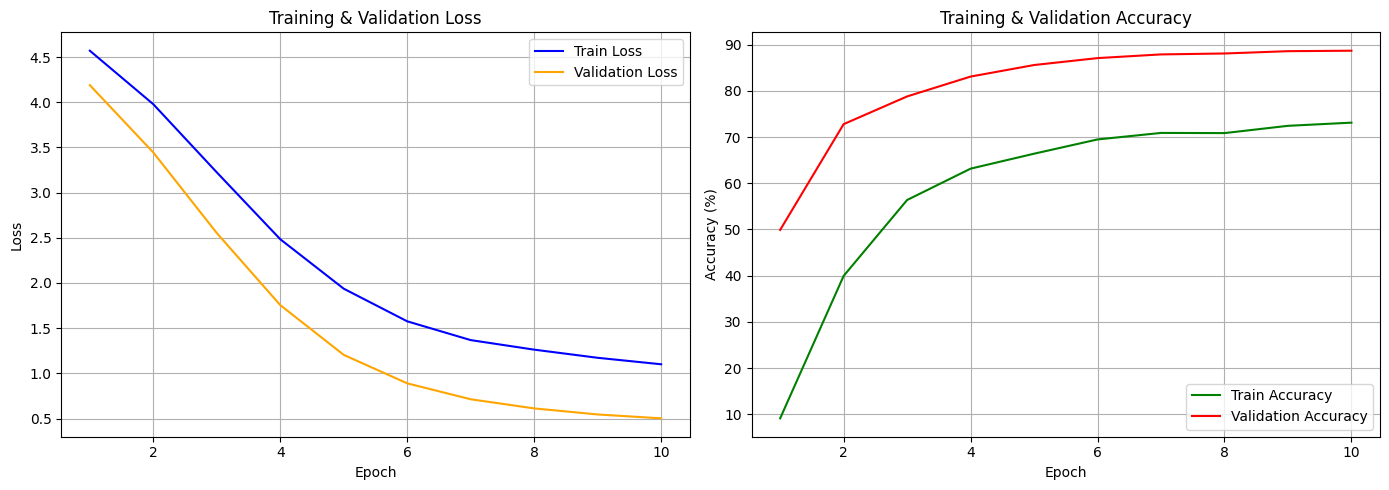

In [65]:
run()

#Evaluate Models

In [66]:
run_test()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 0.4716, Test Accuracy: 90.02%
--- our model Classification Report ---
                                precision    recall  f1-score   support

                 affenpinscher       1.00      1.00      1.00        14
                  afghan_hound       1.00      1.00      1.00        10
           african_hunting_dog       1.00      1.00      1.00        13
                      airedale       0.93      0.93      0.93        15
american_staffordshire_terrier       0.80      0.36      0.50        11
                   appenzeller       1.00      0.25      0.40         8
            australian_terrier       0.90      0.82      0.86        11
                       basenji       0.94      0.88      0.91        17
                        basset       0.92      1.00      0.96        12
                        beagle       0.86      0.92      0.89        13
            bedlington_terrier       0.91      1.00      0.95        10
          bernese_mountain_dog       0.94      1.00   

#Visualize Results

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


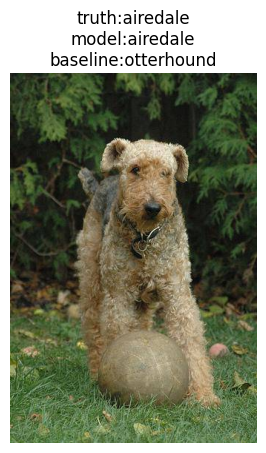

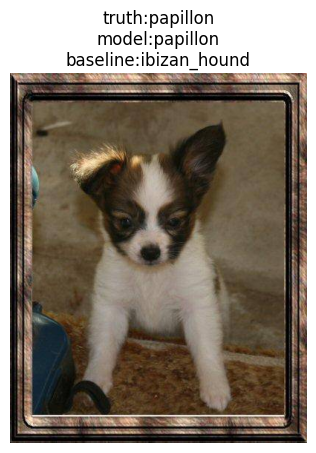

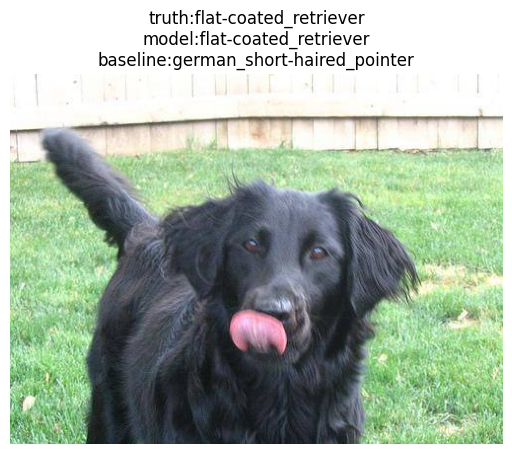

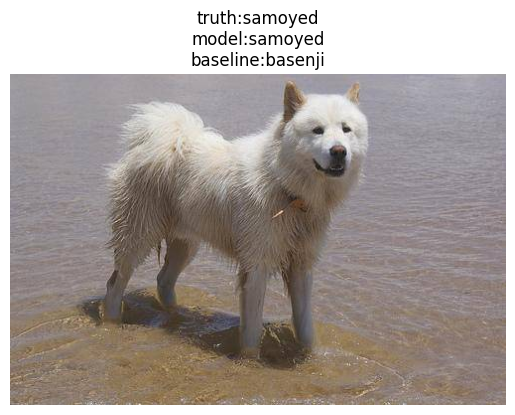

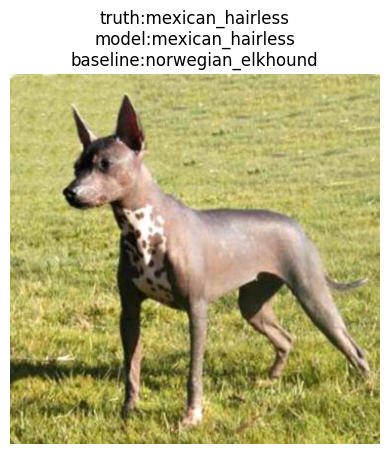

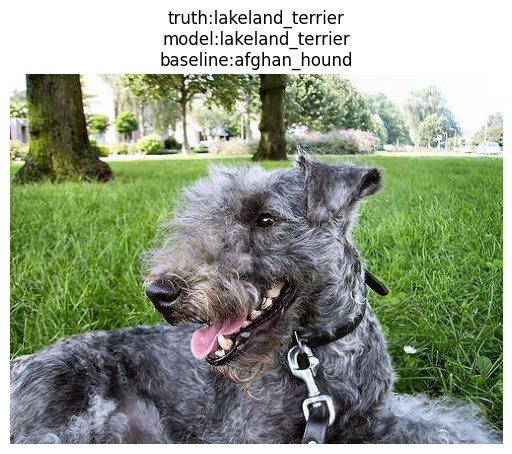

In [75]:
run_test2()